<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe30338-2021](https://jckantor.github.io/cbe30338-2021);
content is available [on Github](https://github.com/jckantor/cbe30338-2021.git).*


<!--NAVIGATION-->
< [3.7 Integral Windup and Bumpless Transfer](https://jckantor.github.io/cbe30338-2021/03.07-Integral-Windup-and-Bumpless-Transfer.html) | [Contents](toc.html) | [4.0 Process Analytics](https://jckantor.github.io/cbe30338-2021/04.00-Process-Analytics.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/03.08-Cascade-Control.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/03.08-Cascade-Control.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 3.8 Cascade Control

## 3.8.1 Learning Goals

## 3.8.2 What is Cascade Control?

Cascade control is a means of coordinating individual controllers to incorporate additional sensors into the regulation of key control variables. To understand how this can work, consider a simple level control system

![](https://cdn.instrumentationtools.com/wp-content/uploads/2016/03/instrumentationtools.com_single-loop-control.png)

What are some typical disturbances?

* Change in feed rate
* Change in viscosity
* Changes in downstream pressure

The controller may do a good job with changes in feed flow rate, but what about changes in downstream pressure? Can we do better?

![](https://cdn.instrumentationtools.com/wp-content/uploads/2016/03/instrumentationtools.com_cascade-control.png)

There is a nomenclature:

* primary (aka outer) control loop for level
* secondary (aka inner) control loop for flow

The job of the secondary flow controller is to maintain a desired flowrate. If it does its job then changes in flow due to downstream pressure, viscosity, or pump performance will be minimized **before** they substantially change in the tank level. The job of the primary level controller is to set the desired flowrate.  It does this by providing a setpoint for operation of the inner loop.

This coordination of primary and secondary level controlers (or outer and inner controllers) uses multiple measurements (level and flow) to accomplish a single control objective (maintain constant level). The result is a faster response to disturbances and improved regulatory control.

## 3.8.3 Cascade Control for the Temperature Control Lab

![](https://jckantor.github.io/cbe30338-2021/figures/cascade_control_1.png)


![](https://jckantor.github.io/cbe30338-2021/figures/cascade_control_2.png)


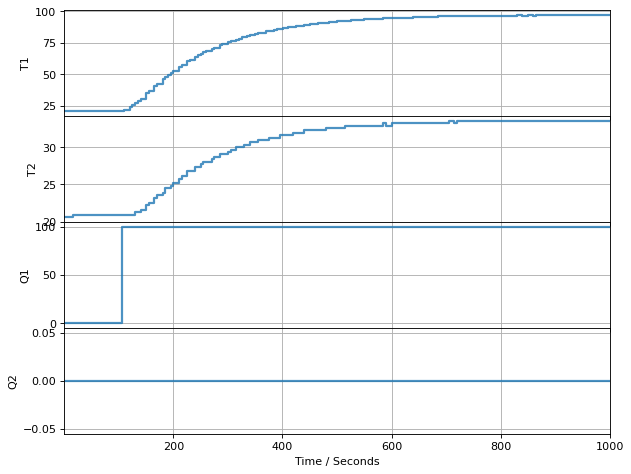

TCLab Model disconnected successfully.


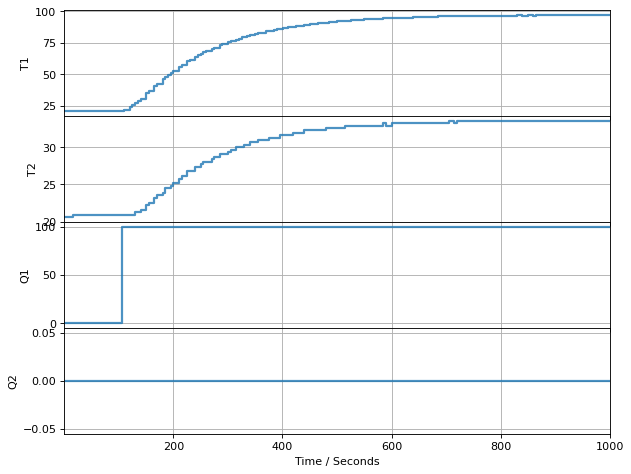

In [10]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

def steptest(t_step=5, t_final=1000,
               MV=lambda t: 100 if t >= 100 else 0):

    TCLab = setup(connected=False, speedup=60)
    with TCLab() as lab:
        h = Historian(lab.sources)
        p = Plotter(h, t_final)

        # initialize manipulated variable
        lab.P1 = 255
        lab.P2 = 0

        # event loop
        for t in clock(t_final, t_step):

            U1 = lab.Q1(MV(t))
            lab.Q1(U1)
            p.update(t)
            
steptest()

In [11]:
K = (34 - 21)/100
tau = 30
T = 180

Kp = 0.9*T/(K*tau)
Ki = 0.3*T/(K*tau**2)

print(Kp, Ki)

controller = PI(Kp, Ki, t_step=5)


41.53846153846153 0.46153846153846156


In [35]:
def PI(Kp, Ki, t_step=1, MV_bar=0, MV_min=0, MV_max=100):
    e_prev = 0
    MV = MV_bar
    while True:
        SP, PV, MV = yield MV
        e = PV - SP
        MV += -Kp*(e - e_prev) - t_step*Ki*e
        MV = max(MV_min, min(MV_max, MV))
        e_prev = e

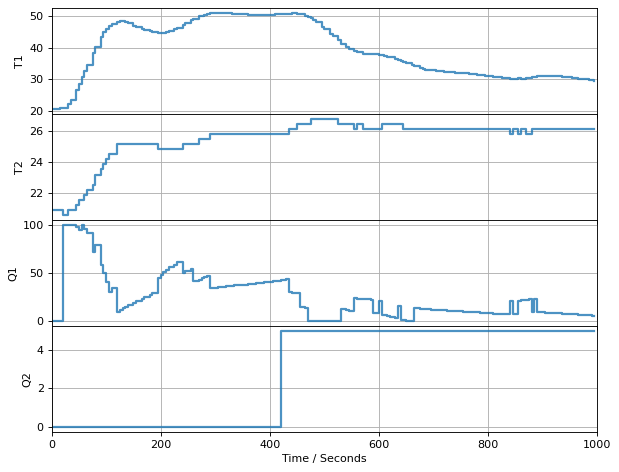

TCLab Model disconnected successfully.


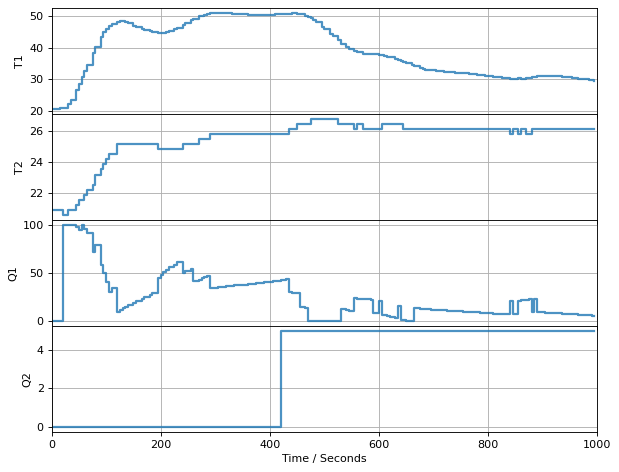

In [38]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

def experiment(controller, t_step=5, t_final=1000,
               SP=lambda t: 26 if t >= 20 else 0,
               DV=lambda t: 5 if t >= 420 else 0):

    TCLab = setup(connected=False, speedup=60)
    with TCLab() as lab:
        h = Historian(lab.sources)
        p = Plotter(h, t_final)

        # initialize manipulated variable
        lab.P1 = 255
        lab.P2 = 255
        lab.Q1(next(controller))

        # event loop
        for t in clock(t_final, t_step):
            T1 = lab.T1
            T2 = lab.T2
            U1 = lab.Q1()
            U1 = controller.send((SP(t), T2, U1))
            lab.Q1(U1)
            lab.Q2(DV(t))
            p.update(t)
            
controller = PI(Kp, Ki, t_step=5)
experiment(controller)

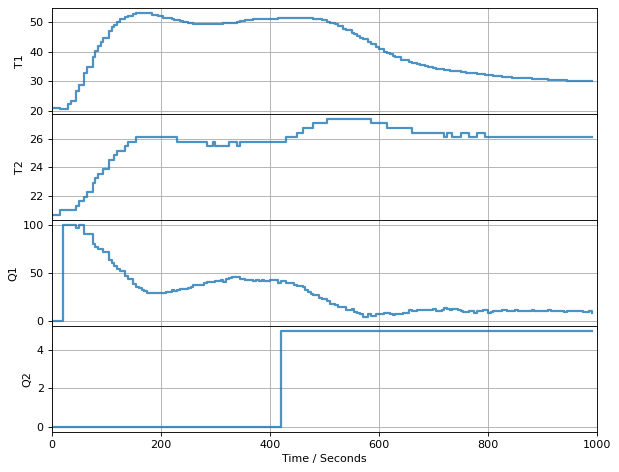

TCLab Model disconnected successfully.


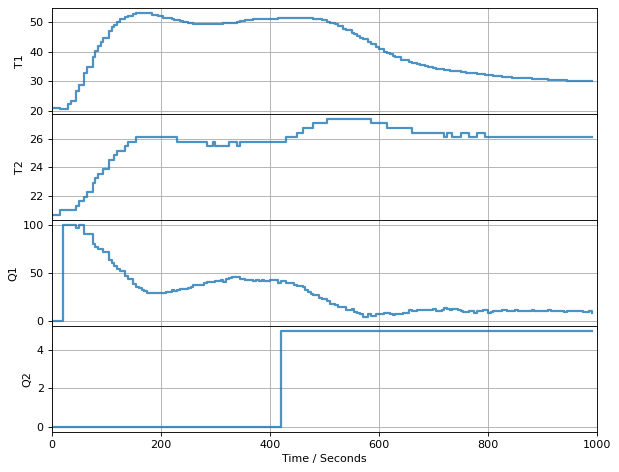

In [39]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

def cascade(outer, inner, t_step=5, t_final=1000,
               SP=lambda t: 26 if t >= 20 else 0,
               DV=lambda t: 5 if t >= 420 else 0):

    TCLab = setup(connected=False, speedup=60)
    with TCLab() as lab:
        h = Historian(lab.sources)
        p = Plotter(h, t_final)

        # initialize manipulated variable
        lab.P1 = 255
        lab.P2 = 255
        lab.Q1(next(inner))
        next(outer)
        SP_inner=SP(0)
        # event loop
        for t in clock(t_final, t_step):
            T1 = lab.T1
            T2 = lab.T2
            U1 = lab.Q1()
            
            SP_inner = outer.send((SP(t), T2, SP_inner))
            U1 = inner.send((SP_inner, T1, U1))
            lab.Q1(U1)
            lab.Q2(DV(t))
            p.update(t)
            
outer_controller = PI(1, .1, t_step=5)
inner_controller = PI(4, .04, t_step=5)
cascade(outer_controller, inner_controller)

## 3.8.4 PI Control

Proportional-Integral (PI) Control is velecity form

\begin{align}
MV_k & = MV_{k-1} - K_P (e_{k} - e_{k-1}) - h K_I e_k
\end{align}

where $MV_0= \bar{MV}$ is the initial value, and the error $e_k$ is the difference between the process variable and setpoint

\begin{align}
e_k & = PV_k - SP_k \\
\end{align}


The following cells demonstrate performance of the controller when subject to a step change in setpoint and a disturbance input.

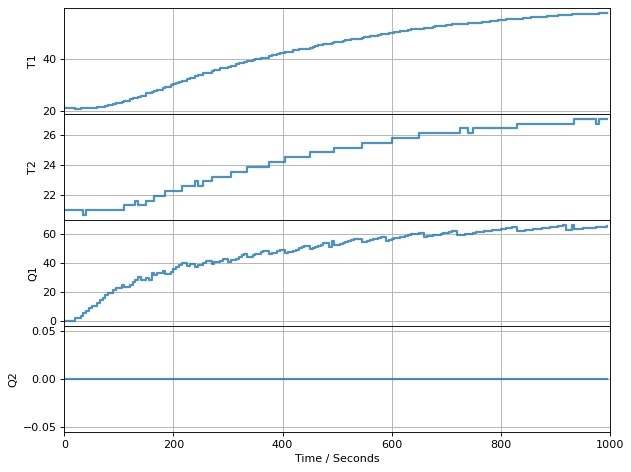

TCLab Model disconnected successfully.


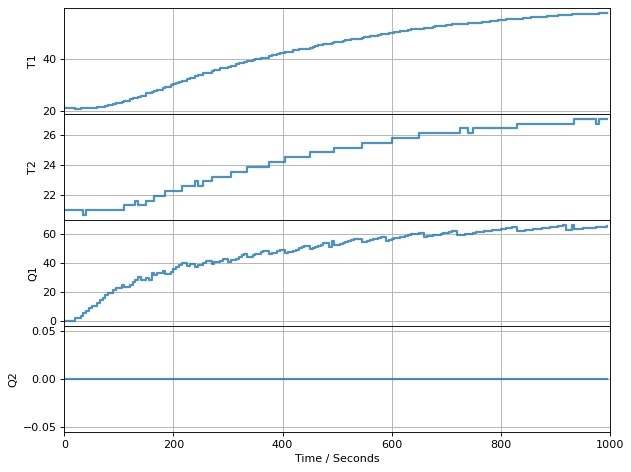

In [8]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

def experiment(controller, t_step=5, t_final=1000,
               SP=lambda t: 28 if t >= 20 else 0):

    TCLab = setup(connected=False, speedup=60)
    with TCLab() as lab:
        h = Historian(lab.sources)
        p = Plotter(h, t_final)

        # initialize manipulated variable
        lab.P1 = 200
        lab.P2 = 200
        lab.Q1(next(controller))

        # event loop
        for t in clock(t_final, t_step):
            T1 = lab.T1
            T2 = lab.T2
            U1 = lab.Q1()
            U1 = controller.send((SP(t), T2, U1))
            lab.Q1(U1)
            p.update(t)
            
controller =  PI(10, 0.05, t_step=5)
experiment(controller)

## 3.8.5 What is Integral (aka Reset) Windup?

In the next cell we're doing an experiment in which we increase the magnitude of the control gains to see if we an acheive even better control performance. Let's see how we do.

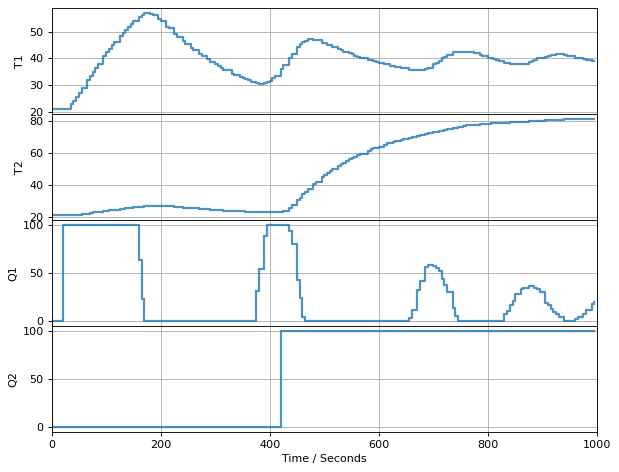

TCLab Model disconnected successfully.


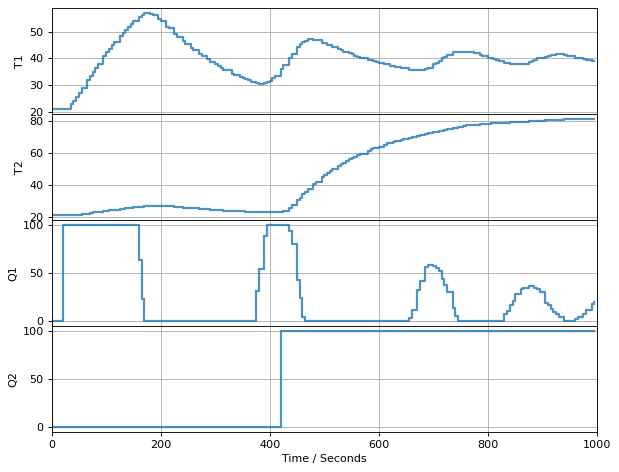

In [44]:
experiment(PI(8, 0.4))

<hr>

**Study Question:** Carefully exammine the results of this experiment. The PI velocity algorithm is given by an equation

\begin{align}
MV_{k} & = MV_{k-1} - K_p(e_{k} - e_{k-1}) - h K_i e_{k}
\end{align}

Looking at the period from 0 to 100 seconds, is this equation being satisfied? Why or why not?  

**Study Question:** Carefully examine the code for the PI controller. How is it possible for $MV$ to be different from the actual input applied to the device?

<hr>

**Integral (aka Reset) windup is a consequence the manipulable input to a process being different from what the control equation specifies for the input. The difference is due to the presence of upper and lower bounds on the manipulated variable.**

### 3.8.5.1 Anti-reset windup - Version 1

There several common strategies for avoiding integral (aka reset) windup. The first of these, which should be part of any practical implementation, is to limit computed values of manipulated variable to the range of allowable values. This will avoid $MV$ 'winding up' due to range limits.

\begin{align}
\hat{MV}_{k} & = MV_{k-1} - K_p(e_{k} - e_{k-1}) - h K_i e_{k} 
\end{align}

\begin{align}
MV_k & = \max(MV^{min}, \min(MV^{max}, \hat{MV}_k)
\end{align}

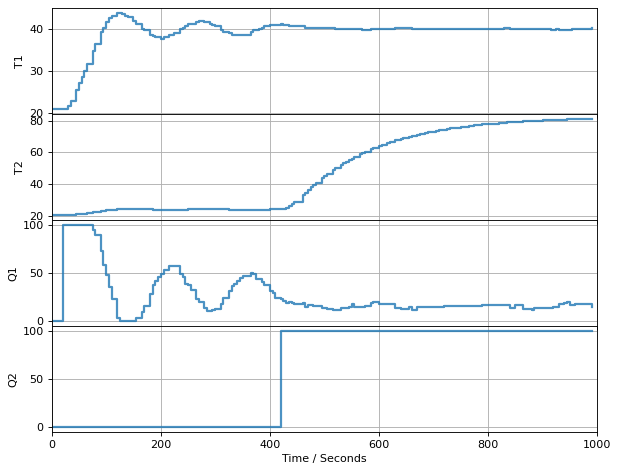

TCLab Model disconnected successfully.


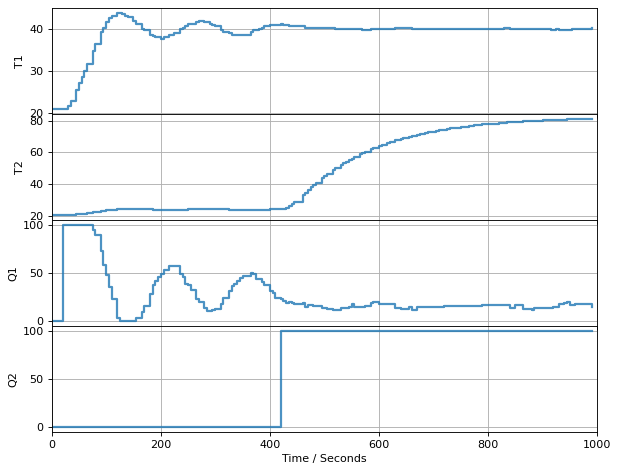

In [45]:
def PI_antiwindup_version_1(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    e_prev = 0
    t_prev = 0
    while True:
        t, SP, PV = yield MV
        e = PV - SP
        MV += - Kp*(e - e_prev) - (t - t_prev)*Ki*e
        MV = max(MV_min, min(MV_max, MV))   # <=== enforce constraints on MV to avoid integral windup
        e_prev = e
        t_prev = t
        
controller = PI_antiwindup_version_1(8, 0.4)
experiment(controller)

### 3.8.5.2 Anti-reset Windup - Version 2

A more subtle form of windup occurs when the manipulated variable is subject to external interventions. This can occur when a valve stem in a process application gets stuck, an operator or user intervenes and resets a mechanical actuator, or there is some sort of system failure. 

For these reasons, practical control systems often include a field measurement of the manipulated variable that is fed back to the controller. The following image, for example, shows a pneumatically operated globe valve with a positioner, and with feedback of position to the central control system.

<p><a href="https://commons.wikimedia.org/wiki/File:Pl_control_valve.jpg#/media/File:Pl_control_valve.jpg"><img src="https://upload.wikimedia.org/wikipedia/commons/b/b2/Pl_control_valve.jpg" alt="Pl control valve.jpg" height="720" width="540"></a>
    
 <a href="https://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>
    
Stepper motors are commonly used actuators in lab equipment and robotics. The position of the stepper motor would be manipulated variable. This is an example of a stepper motor with an integrated encoder that can be used to verify the motor's position.
    
![](https://www.portescap.com/-/media/project/automation-specialty/portescap/portescap/products/workings-of-encoders/encoder_chart_720x450_1_0.jpg)

This behavior also occurs in the Temperature Control Laboratory in which the manipulated power levels are constrained to the range 0% to 100%. This is demonstated in the following cell.

In [57]:
# show that inputs to the TCLab are constrained to the range 0 to 100%

TCLab = setup(connected=False, speedup=20)
with TCLab() as lab:
    print(f"Q1 = {lab.Q1()}")
    lab.Q1(150)
    print(f"Q1 = {lab.Q1()}")

TCLab version 0.4.9
Simulated TCLab
Q1 = 0
Q1 = 100
TCLab Model disconnected successfully.


To accomodate feedback of the manipulated variable, we first need to modify the event loop to incorporate the measurement of the manipulated variable, then send that value to the controller.

In [58]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

def experiment(controller, t_final=1000, t_step=5,
               SP=lambda t: 40 if t >= 20 else 0, 
               DV=lambda t: 100 if t >= 420 else 0):
    TCLab = setup(connected=False, speedup=60)
    with TCLab() as lab:

        # set up historian and plotter
        h = Historian(lab.sources)
        p = Plotter(h, t_final)

        # initialize manipulated variable
        lab.P1 = 200
        lab.Q1(next(controller))

        # event loop
        for t in clock(t_final, t_step):
            T1 = lab.T1
            U1 = lab.Q1()                            # <==== new line
            U1 = controller.send((t, SP(t), T1, U1))    # <==== send U1 to controller 
            lab.Q1(U1)
            lab.Q2(DV(t))
            p.update(t)     

The next change is to the controller. The controller now accepts values for PV, SP, and, additionally, MV. To demonstrate the impact of these changes, this example will comment out the software limits placed on MV to show that feedback of manipulated variable is also an anti-reset windwup strategy.

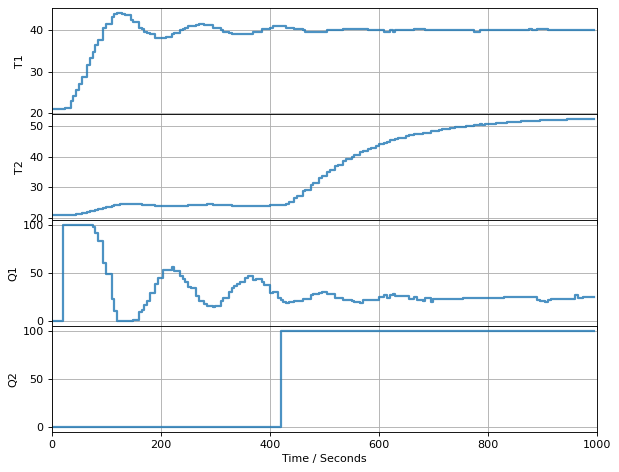

TCLab Model disconnected successfully.


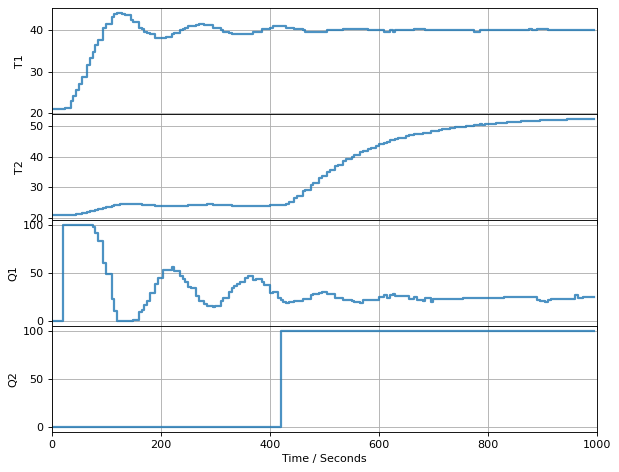

In [59]:
def PI_antiwindup_version_2(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    e_prev = 0
    t_prev = 0
    while True:
        t, SP, PV, MV = yield MV   # <==== now gets MV from experiment
        e = PV - SP
        MV += -Kp*(e - e_prev) - (t - t_prev)*Ki*e
        e_prev = e
        t_prev = t
        
controller = PI_antiwindup_version_2(8, 0.4)
experiment(controller)

### 3.8.5.3 Anti-reset Windup

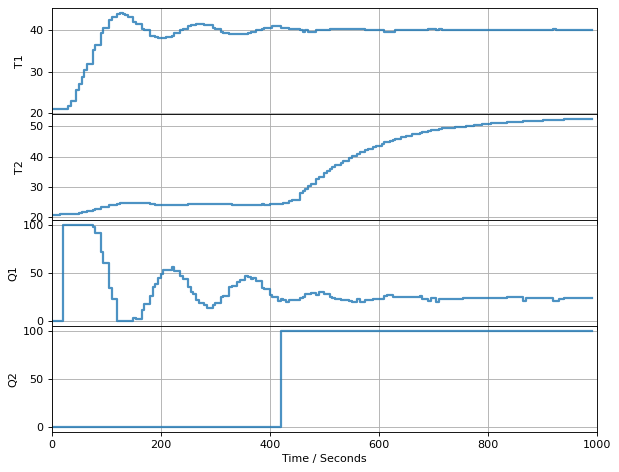

TCLab Model disconnected successfully.


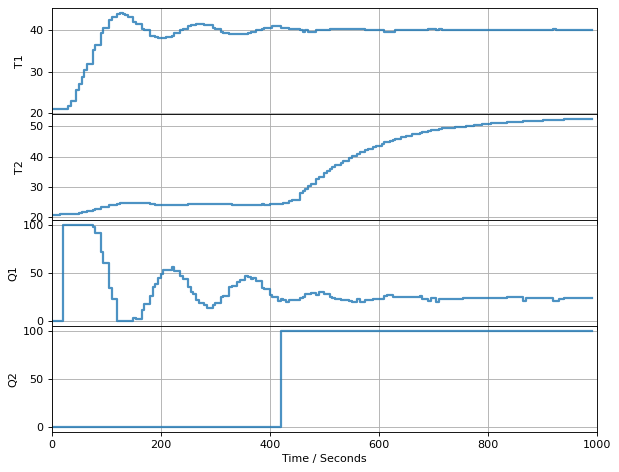

In [60]:
def PI_antiwindup(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    e_prev = 0
    t_prev = 0
    while True:
        t, SP, PV, MV = yield MV 
        e = PV - SP
        MV += -Kp*(e - e_prev) - (t - t_prev)*Ki*e 
        MV = max(MV_min, min(MV_max, MV))
        e_prev = e
        t_prev = t
        
experiment(PI_antiwindup(8, 0.4))

## 3.8.6 Manual Operation

Manual operation allows the user to specify the manipulated variable.  Set $SP = PV$.

In [ ]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

def experiment(controller, t_final=450, t_step=2,
               SP=lambda t: 40 if t >= 20 else 0, 
               DV=lambda t: 100 if t >= 420 else 0,
               MV=lambda t: 25 if t <= 100 else None):
    TCLab = setup(connected=False, speedup=60)
    with TCLab() as lab:

        # set up historian and plotter
        h = Historian(lab.sources)
        p = Plotter(h, t_final)

        # initialize manipulated variable
        lab.P1 = 200
        lab.Q1(next(controller))

        # event loop
        for t in clock(t_final, t_step):
            T1 = lab.T1
            U1 = lab.Q1()
            if MV(t) is None:
                U1 = controller.send((t, SP(t), T1, U1))
            else:
                U1 = controller.send((t, T1, T1, MV(t)))    # <=== to fix U1 = MV(t) use SP = PV
            lab.Q1(U1)
            lab.Q2(DV(t))
            p.update(t)  
            
controller = PI_antiwindup(8, 0.4)
experiment(controller)

## 3.8.7 Bumpless Transfer

* Remove setpoint from proportional term

### 3.8.7.1 Bumpless Transfer

\begin{align}
\hat{MV}_{k} & = MV_{k-1} - K_p(PV_{k} - PV_{k-1}) - h K_i e_{k} 
\end{align}

\begin{align}
MV_k & = \max(MV^{min}, \min(MV^{max}, \hat{MV}_k)
\end{align}

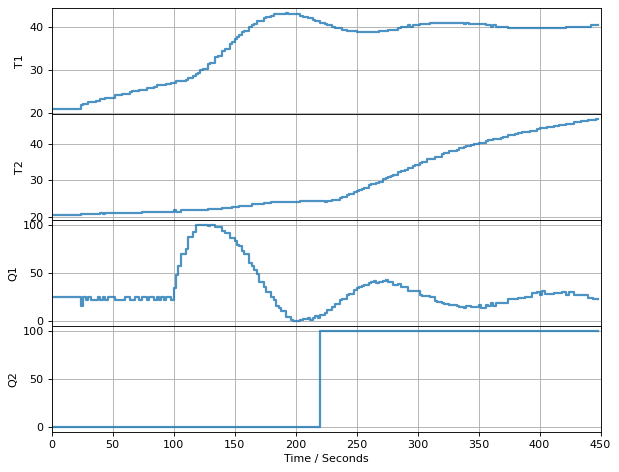

TCLab Model disconnected successfully.


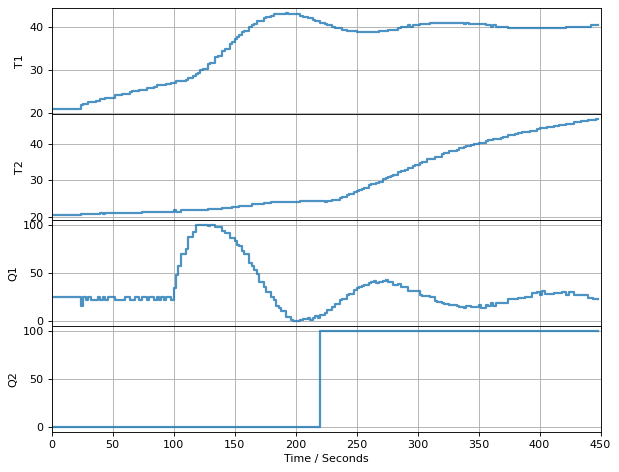

In [18]:
def PI_antiwindup(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    
    t, SP, PV, MV = yield MV_bar
    MV += -Ki*(PV - SP)
    MV = max(MV_min, min(MV_max, MV))
    PV_prev = PV
    while True:
        SP, PV, MV = yield MV 
        MV += -Kp*(PV - PV_prev) - Ki*(PV - SP)
        MV = max(MV_min, min(MV_max, MV))
        PV_prev = PV
        
controller = PI_antiwindup(10, 1.0)
experiment(controller)

<!--NAVIGATION-->
< [3.7 Integral Windup and Bumpless Transfer](https://jckantor.github.io/cbe30338-2021/03.07-Integral-Windup-and-Bumpless-Transfer.html) | [Contents](toc.html) | [4.0 Process Analytics](https://jckantor.github.io/cbe30338-2021/04.00-Process-Analytics.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/03.08-Cascade-Control.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/03.08-Cascade-Control.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>